# Prediction Of Singapore HDB Prices

## Preparation

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy.stats import iqr
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression,ElasticNetCV,\
RidgeCV,LassoCV,Ridge,Lasso,ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, \
cross_val_predict,GridSearchCV,cross_validate
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
import csv
warnings.filterwarnings('ignore')

### Read Csv into data frame

In [2]:
df = pd.read_csv("../data/train.csv")
df.head(2)

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,...,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,...,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892


## Data cleaning and feature selection

### Check shape, nulls, zeroes and data type

* Created a function to print out columns with null or zero values, and see the data types of the features
* Check the unique values in the columns

In [3]:
def check_dataframe_shape_null_zeroes(df):
    print(f"Data frame shape: {df.shape}")
    print("\n")
    nulls = {k:v for k,v in dict(df.isnull().sum()).items() if v>0}
    for k,v in nulls.items():
        print(f"Empty rows in column [{k}]: {v}")
    print("\n")
    zeroes = {k:v for k,v in dict(df[df == 0].count()).items() if v>0}
    for k,v in zeroes.items():
        print(f"Rows with zeroes in column [{k}]: {v}")
    print("\n")

    column_types = {str(k):list(v) for k,v in df.groupby(df.dtypes,axis=1)}
    for k,v in column_types.items():
        print(f"Columns with data type [{k}]:{v}")
        print("\n")
check_dataframe_shape_null_zeroes(df)

Data frame shape: (150634, 77)


Empty rows in column [Mall_Nearest_Distance]: 829
Empty rows in column [Mall_Within_500m]: 92789
Empty rows in column [Mall_Within_1km]: 25426
Empty rows in column [Mall_Within_2km]: 1940
Empty rows in column [Hawker_Within_500m]: 97390
Empty rows in column [Hawker_Within_1km]: 60868
Empty rows in column [Hawker_Within_2km]: 29202


Rows with zeroes in column [1room_sold]: 150552
Rows with zeroes in column [2room_sold]: 144324
Rows with zeroes in column [3room_sold]: 95671
Rows with zeroes in column [4room_sold]: 30379
Rows with zeroes in column [5room_sold]: 62782
Rows with zeroes in column [exec_sold]: 124614
Rows with zeroes in column [multigen_sold]: 150557
Rows with zeroes in column [studio_apartment_sold]: 149226
Rows with zeroes in column [1room_rental]: 150332
Rows with zeroes in column [2room_rental]: 148770
Rows with zeroes in column [3room_rental]: 146805
Rows with zeroes in column [other_room_rental]: 150602
Rows with zeroes in column [Mall_

In [4]:
len(df['full_flat_type'].unique())

43

In [5]:
len(df['flat_model'].unique())

20

In [6]:
df.groupby("flat_type")['flat_model'].value_counts()

flat_type         flat_model            
1 ROOM            Improved                     82
2 ROOM            Model A                     739
                  Standard                    594
                  Improved                    521
                  Premium Apartment            37
                  2-room                        4
                  DBSS                          1
3 ROOM            New Generation            15227
                  Improved                  10240
                  Model A                    8454
                  Standard                   2522
                  Simplified                 1930
                  Premium Apartment           417
                  DBSS                        184
                  Terrace                      86
4 ROOM            Model A                   35127
                  New Generation             8139
                  Premium Apartment          7667
                  Simplified                 5309
         

### Feature Engineering

* Added feature to indicate the HDB age at the time of transaction

In [7]:
df['hdb_age_at_tranc'] = df['Tranc_Year']-df['lease_commence_date']

### Imputation of null values
* Null values are imputed iwth mean, so we can still include the rows for model training

In [8]:
col = ['Hawker_Within_2km','Mall_Within_2km', 'Mall_Nearest_Distance' ]
for i in col:
    mean = np.mean(df[i])
    df[i].fillna(value=mean, inplace=True)

### Manual splitting into categories and numerical features

* Manually flagged which features are important based on description, analysis and number of null values
* Table below shows the selected features list

In [9]:
numerical_columns = []
categorical_columns = []
filename = "../data/data_dictionary_analysis.csv"
data_dict = pd.read_csv(filename)
with open(filename,'r') as data:
    reader = csv.reader(data)
    next(reader, None)  # skip the headers
    for line in reader:
        if line[3]=='1' and line[4] == 'numerical':
            numerical_columns.append(line[1])
        if line[3]=='1' and line[4] == 'Categorical':
            categorical_columns.append(line[1])

pd.set_option('display.max_colwidth', None)
data_dict = data_dict.loc[data_dict['X']==1][['Feature','Description','Data type']]
data_dict

,Feature,Description,Data type
3,flat_type,"type of the resale flat unit, e.g. 3 ROOM",Categorical
7,floor_area_sqm,floor area of the resale flat unit in square metres,numerical
8,flat_model,"HDB model of the resale flat, e.g. Multi Generation",Categorical
10,Tranc_Year,year of resale transaction,Categorical
15,mid,middle value of storey_range,numerical
20,max_floor_lvl,highest floor of the resale flat,numerical
43,planning_area,Government planning area that the flat is located,Categorical
54,mrt_nearest_distance,distance (in metres) to the nearest MRT station,numerical
76,hdb_age_at_tranc,hdb age during the transaction date,numerical


### Check data types

* Double check the data type of the dataframe agrees with numerical and categorical classification

In [10]:
for i in numerical_columns:
    print(f"Column [{i}] has data type [{df[i].dtype}]")
    
for i in categorical_columns:
    print(f"Column [{i}] has data type [{df[i].dtype}] has unique counts [{len(set(df[i]))}]")

Column [floor_area_sqm] has data type [float64]
Column [mid] has data type [int64]
Column [max_floor_lvl] has data type [int64]
Column [mrt_nearest_distance] has data type [float64]
Column [hdb_age_at_tranc] has data type [int64]
Column [flat_type] has data type [object] has unique counts [7]
Column [flat_model] has data type [object] has unique counts [20]
Column [Tranc_Year] has data type [int64] has unique counts [10]
Column [planning_area] has data type [object] has unique counts [32]


## EDA

### Correlation heat map of numerical columns

* Check the correlation of numerical values with resale prices
* The highest feature is floor area and max floor level or mid storey

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0.5, 0, 'floor_area_sqm'),
  Text(1.5, 0, 'mid'),
  Text(2.5, 0, 'max_floor_lvl'),
  Text(3.5, 0, 'mrt_nearest_distance'),
  Text(4.5, 0, 'hdb_age_at_tranc'),
  Text(5.5, 0, 'resale_price')])

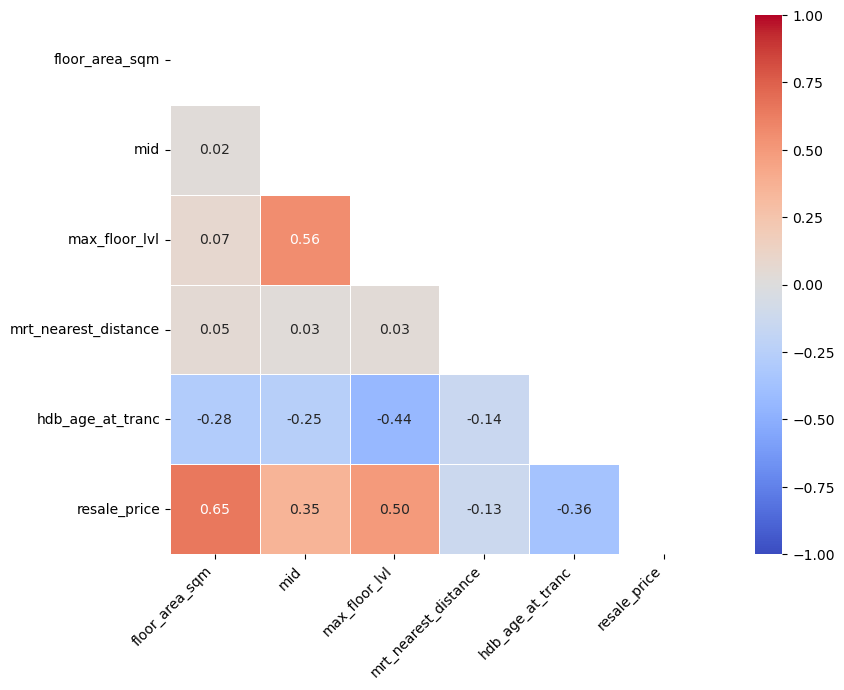

In [11]:
# Use Seaborn's heatmap with pandas .corr() to visualize correlations between all numeric features.
corr = df[numerical_columns+['resale_price']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (12,7))
sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5, cmap = "coolwarm",fmt='.2f')
plt.xticks(rotation=45, ha='right') 

### Bar charts for categorical features

* Visualise the distribution of flat type, flat model, transaction year amd planning area

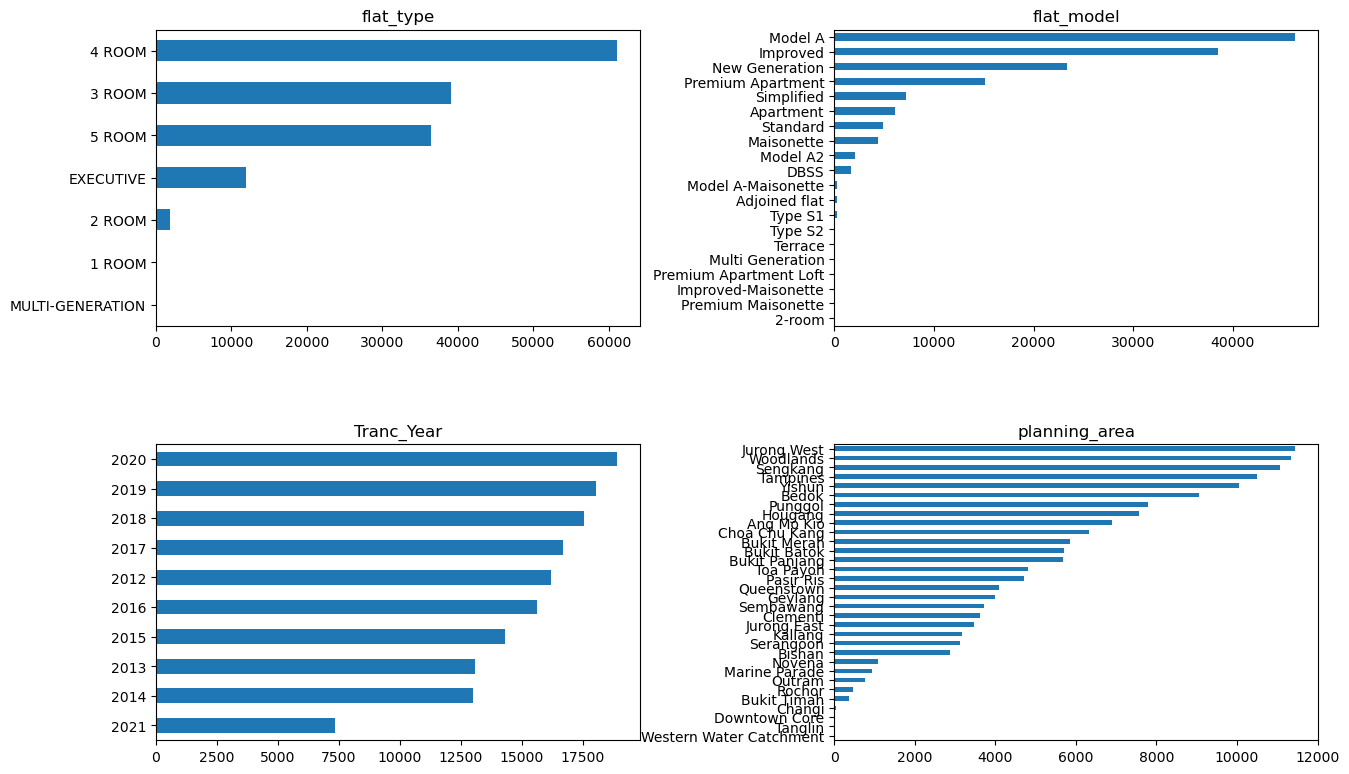

In [12]:
fig1 = plt.figure(figsize=(15,20))
fig1.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(categorical_columns):
    fig1.add_subplot(4,2,idx+1)
    df[d].value_counts().sort_values().plot(kind='barh')
    plt.title(d)

### Histogram for numerical features

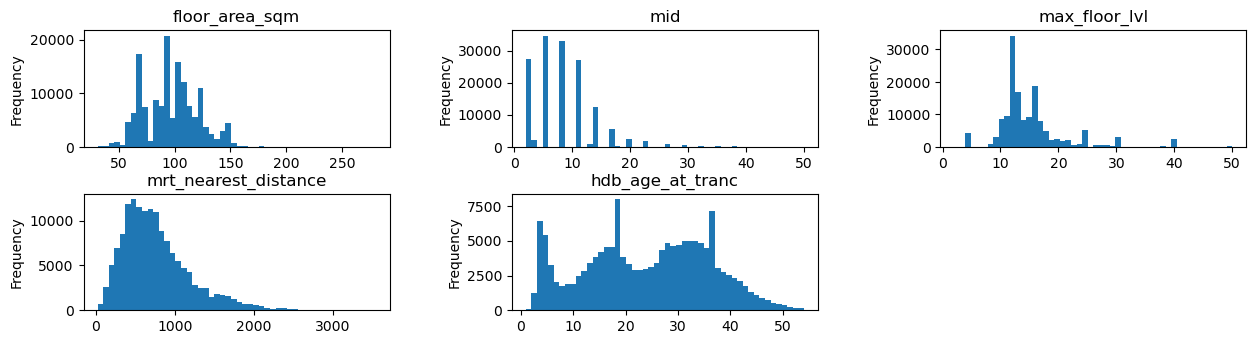

In [13]:
fig1b = plt.figure(figsize=(15,10))
fig1b.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(numerical_columns):
    fig1b.add_subplot(5,3,idx+1)
    df[d].plot(kind='hist',bins=50,title=d)

### Scatter plots by Flat Model

Grouping by Flat model, the resale prices and floor area shows some linear correlation

In [14]:
list(df['flat_type'].value_counts()[:3].index)

['4 ROOM', '3 ROOM', '5 ROOM']

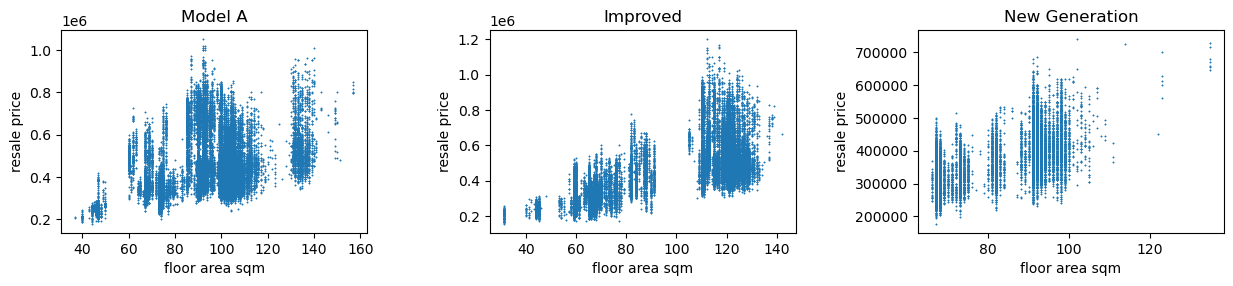

In [15]:
fig3 = plt.figure(figsize=(15,10))
fig3.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(df['flat_model'].value_counts()[:3].index):
    x = df.loc[df['flat_model']==d]['floor_area_sqm']
    y = df.loc[df['flat_model']==d]['resale_price']
    fig3.add_subplot(3,3,idx+1)
    plt.scatter(x,y, marker='*',s=0.1)
    plt.xlabel('floor area sqm')
    plt.ylabel('resale price')
    plt.title(d)

### Scatter plots by Planning area

After grouping by planning area, we can see stronger linear correlation between floor area and resale prices

In [16]:
list(df['planning_area'].value_counts()[:3].index)

['Jurong West', 'Woodlands', 'Sengkang']

fig4 = plt.figure(figsize=(15,40))
fig4.subplots_adjust(hspace=0.4,wspace=0.4)
for idx, d in enumerate(['Jurong West', 'Woodlands', 'Sengkang']):
    x = df.loc[(df['planning_area']==d)]['floor_area_sqm']
    y = df.loc[(df['planning_area']==d)]['resale_price']
    fig4.add_subplot(11,3,idx+1)
    plt.scatter(x,y, marker='*',s=0.1)
    plt.xlabel('floor area sqm')
    plt.ylabel('resale price')
    plt.title(d)

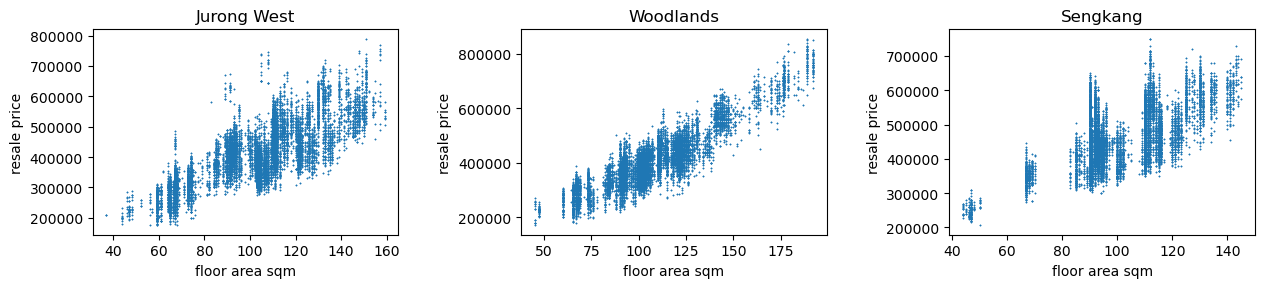

In [17]:
fig4 = plt.figure(figsize=(15,40))
fig4.subplots_adjust(hspace=0.4,wspace=0.4)
for idx, d in enumerate(['Jurong West', 'Woodlands', 'Sengkang']):
    x = df.loc[(df['planning_area']==d)]['floor_area_sqm']
    y = df.loc[(df['planning_area']==d)]['resale_price']
    fig4.add_subplot(11,3,idx+1)
    plt.scatter(x,y, marker='*',s=0.1)
    plt.xlabel('floor area sqm')
    plt.ylabel('resale price')
    plt.title(d)

### Notes:
* Resale prices are more linearly correlated with floor area when grouped by planning areas than flat type

## Finding Outliers
* Scatter plot to check for outliers
* Box plots to focus on outliers for selected planning area
* Remove outliers from the dataset

Text(0.5, 1.0, 'Floor Area vs resale price')

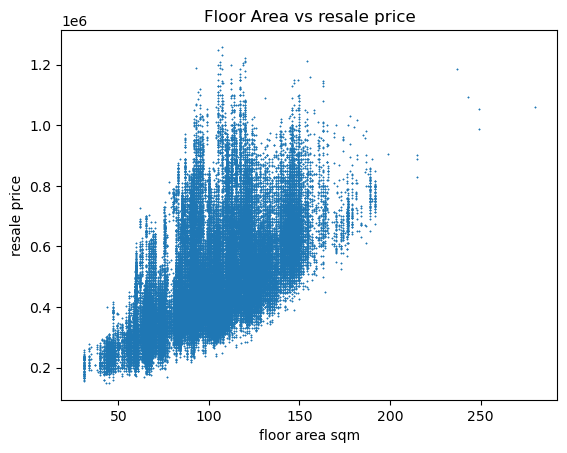

In [18]:
x = df['floor_area_sqm']
y = df['resale_price']
plt.scatter(x,y, marker='*',s=0.1)
plt.xlabel('floor area sqm')
plt.ylabel('resale price')
plt.title('Floor Area vs resale price')

### Removing outliers

In [19]:
col = 'planning_area'

In [20]:
def get_iqr(df):
    Q1 = np.percentile(df['resale_price'], 50)
    Q3 = np.percentile(df['resale_price'], 75)
    return (Q3 - Q1)

threshold = get_iqr(df)
threshold

100000.0

In [21]:
pd.options.display.float_format = '{:.2f}'.format
outliers_1 = df.groupby('planning_area')['resale_price'].agg(iqr).sort_values(ascending=False)[:15]
outliers_1 

planning_area
Outram          480000.00
Queenstown      390000.00
Bukit Merah     355000.00
Toa Payoh       339888.00
Bukit Timah     318400.00
Novena          312000.00
Tanglin         305000.00
Kallang         295000.00
Geylang         265000.00
Bishan          240000.00
Clementi        225000.00
Serangoon       214000.00
Jurong East     190000.00
Marine Parade   183000.00
Bedok           182000.00
Name: resale_price, dtype: float64

In [22]:
outliers = list(outliers_1.index)
outliers

['Outram',
 'Queenstown',
 'Bukit Merah',
 'Toa Payoh',
 'Bukit Timah',
 'Novena',
 'Tanglin',
 'Kallang',
 'Geylang',
 'Bishan',
 'Clementi',
 'Serangoon',
 'Jurong East',
 'Marine Parade',
 'Bedok']

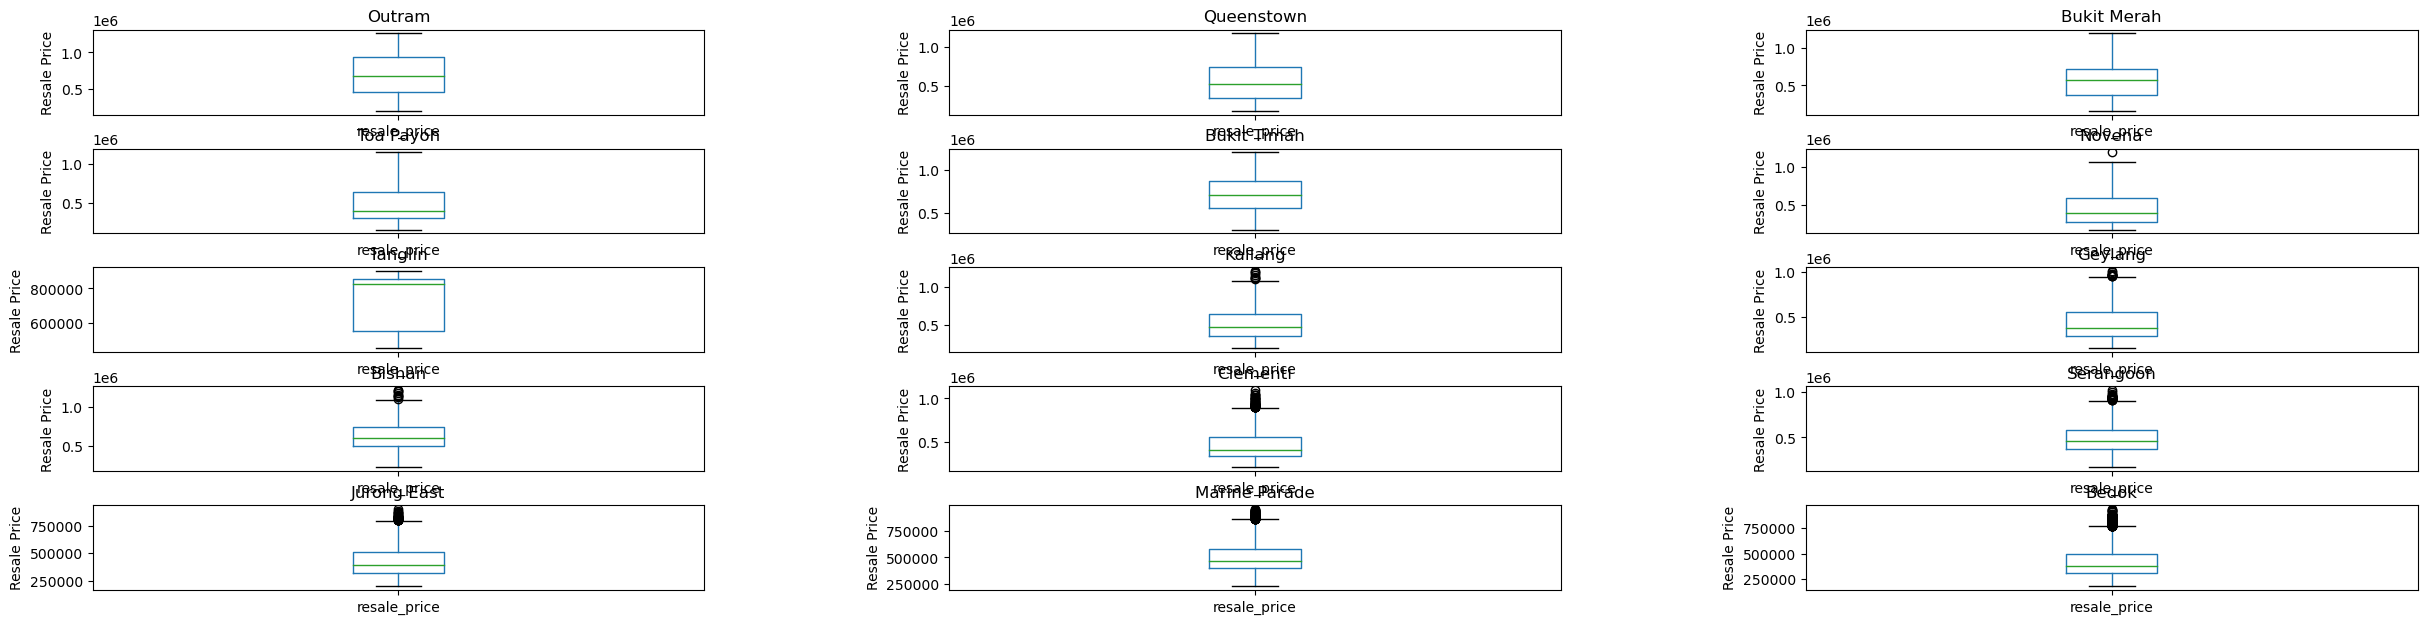

In [23]:
fig2 = plt.figure(figsize=(30,15))
fig2.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(outliers):
    fig2.add_subplot(10,3,idx+1)
    bp = df.loc[df[col]==d].boxplot(column='resale_price', grid=False)
    plt.ylabel('Resale Price')
    plt.title(d)

In [24]:
print(f"Before Original DataFrame : {df.shape}")

df_outlier = df.loc[df[col].isin(outliers)]
df = df.loc[~df[col].isin(outliers)]

print(f"Main Dataframe: {df.shape}")
print(f"Outliers DataFrame: {df_outlier.shape}")

Before Original DataFrame : (150634, 78)
Main Dataframe: (103374, 78)
Outliers DataFrame: (47260, 78)


### Check the outliers are removed from main dataframe by plotting boxplots

### Plot scatter plot again to check if outliers are removed

Text(0.5, 1.0, 'Floor Area vs resale price')

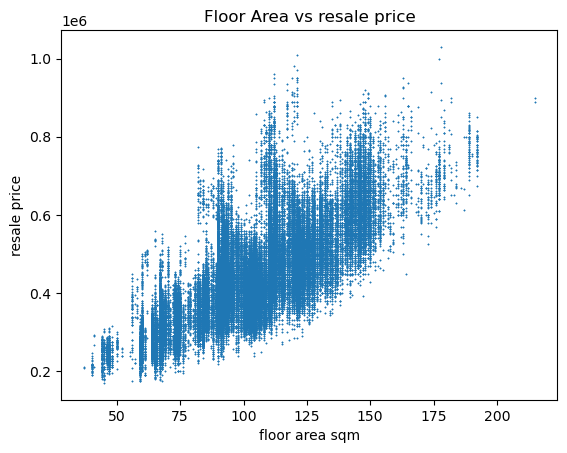

In [25]:
x = df['floor_area_sqm']
y = df['resale_price']
plt.scatter(x,y, marker='*',s=0.1)
plt.xlabel('floor area sqm')
plt.ylabel('resale price')
plt.title('Floor Area vs resale price')

Text(0.5, 1.0, 'Floor Area vs resale price (Outliers)')

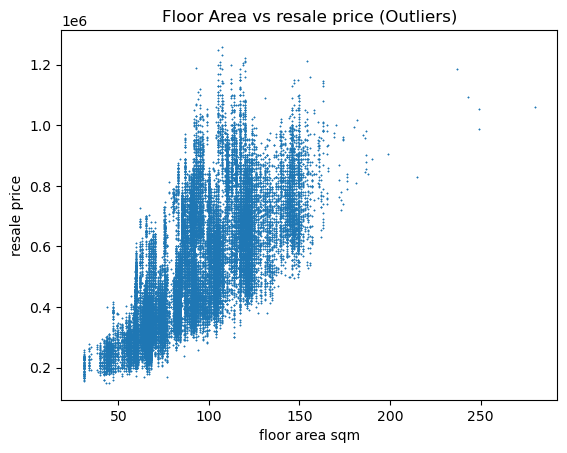

In [26]:
x = df_outlier['floor_area_sqm']
y = df_outlier['resale_price']
plt.scatter(x,y, marker='*',s=0.1)
plt.xlabel('floor area sqm')
plt.ylabel('resale price')
plt.title('Floor Area vs resale price (Outliers)')

## Notes: 
* Above 2 plots illustrated the attempt to split the dataset into 2 more linearly correlated plots by splitting on subsets of planning areas
* Outcome looks better than original combined dataset
* The criteria to split based on planning areas is the interquartile of the resale flat prices
* However, the outlier dataset still appears to have 2 separate gradients, most likely due to flat model outliers

## Feature Engineering and Train Test Split

### Setup features and target

* Let X be the combination of selected numerical and categorical columns
* Let y be the target resale price column
* Double check if there are empty or null values in X

In [27]:
X= df[numerical_columns+categorical_columns]
y= df['resale_price']

X_o= df_outlier[numerical_columns+categorical_columns]
y_o= df_outlier['resale_price']

nulls = {k:v for k,v in dict(X.isnull().sum()).items() if v>0}
for k,v in nulls.items():
    print(f"Empty rows in column [{k}]: {v}")
    
nulls = {k:v for k,v in dict(X_o.isnull().sum()).items() if v>0}
for k,v in nulls.items():
    print(f"Empty rows in column [{k}]: {v}")
    
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_o,y_o,test_size = 0.2,random_state = 42)

## Model Building

* We will be using linear regression with regularisation
* Create a pipeline with 2 steps: 
1. Preprocessing of numerical columns using standard scaler, and categorical columns with one hot encoding
2. Estimation using Linear regression or Ridge Regression

In [28]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

In [29]:
#%%time
#
#def gs_fit(X_train,y_train):
#        """
#        Function to grid search each model with its hyperparameters
#        """
#        
#        models = {
#            'LinearRegression': LinearRegression(),
#            'Ridge': Ridge(),
#            'Lasso': Lasso()
#        }
#        
#        params = {
#            'LinearRegression':{ 
#                    },
#            'Ridge': {
#                'Estimator__alpha': [0.001, 0.01, 0.1,1,10]
#                },
#            'Lasso': {
#                'Estimator__alpha': [0.001, 0.01]
#                }  
#        }
#
#        for name in models.keys():
#            est = models[name]
#            est_params = params[name]
#            pipe = Pipeline([
#                ('Preprocessor',preprocessor),
#                ('Estimator', est)])
#            gs = GridSearchCV(pipe, cv=5,scoring='neg_root_mean_squared_error',param_grid=est_params)
#            gs.fit(X_train, y_train)
#            print(f"Best Score for {name}: {-gs.best_score_}")
#            print(f"Best Params for {name}: {gs.best_params_}")
#            
#gs_fit(X_train,y_train)

### Model selection
* After running through the grid search, Ridge appears to give the lowest RMSE socre, so we will stick to using Ridge

In [30]:
%%time
model = Ridge()
pipe = make_pipeline(preprocessor, model)
hyperparameters = {'ridge__alpha': [0.001, 0.01, 0.1,1,10]}
gs = GridSearchCV(pipe, hyperparameters,cv=5,scoring='neg_root_mean_squared_error')
gs.fit(X_train,y_train)
print(f"Best Score: {-gs.best_score_}")
print(f"Best Params: {gs.best_params_}")

Best Score: 39179.011525412556
Best Params: {'ridge__alpha': 0.01}
CPU times: total: 22.9 s
Wall time: 8.84 s


In [31]:
%%time
model = Ridge()
pipe = make_pipeline(preprocessor, model)
hyperparameters = {'ridge__alpha': [0.001, 0.01, 0.1,1,10]}
gs_o = GridSearchCV(pipe, hyperparameters,cv=5,scoring='neg_root_mean_squared_error')
gs_o.fit(X_train_o,y_train_o)
print(f"Best Score for outlier: {-gs_o.best_score_}")
print(f"Best Params for outlier: {gs_o.best_params_}")

Best Score for outlier: 54259.37358585349
Best Params for outlier: {'ridge__alpha': 0.1}
CPU times: total: 11.5 s
Wall time: 4.13 s


In [32]:
results = pd.DataFrame(gs.cv_results_)
results_o = pd.DataFrame(gs_o.cv_results_)

## Notes:

* By separating the dataset into main and outlier, the main model has a better RMSE score.

## Model Evaluation

In [33]:
predicted = gs.best_estimator_.predict(X_test)
mse = metrics.mean_squared_error(y_test, predicted)
print(f"Test score = {np.sqrt(mse):.3f}")
print("The mean cross-validation rmse is: "
      f"{-results['mean_test_score'].mean():.0f} ± {results['std_test_score'].mean():.0f}")

predicted = gs_o.best_estimator_.predict(X_test_o)
mse = metrics.mean_squared_error(y_test_o, predicted)
print(f"Test score for outlier = {np.sqrt(mse):.3f}")
print("The mean cross-validation rmse for outlier is: "
      f"{-results_o['mean_test_score'].mean():.0f} ± {results_o['std_test_score'].mean():.0f}")

Test score = 39220.368
The mean cross-validation rmse is: 39207 ± 287
Test score for outlier = 54169.099
The mean cross-validation rmse for outlier is: 54283 ± 492


In [34]:
def get_coeffs_from_gs(gs):
    coefficients = gs.best_estimator_[1].coef_
    out_columns_numerical = gs.best_estimator_[0].transformers_[1][2]
    out_columns_category = list(gs.best_estimator_[0].transformers_[0][1].get_feature_names())
    out_columns = out_columns_category+out_columns_numerical
    gs_coef = sorted(list(zip(np.round(coefficients,3),out_columns)),key=lambda x: x[0],reverse=True)
    return gs_coef

In [35]:
coefs = get_coeffs_from_gs(gs)
print("Flat Type")
print(*[x for x in coefs if "x0" in x[1]],sep='\n')
print("Flat Model")
print(*[x for x in coefs if "x1" in x[1]],sep='\n')
print("Transaction Year")
print(*[x for x in coefs if "x2" in x[1]],sep='\n')
print("Planning Area")
print(*[x for x in coefs if "x3" in x[1]],sep='\n')
print("Numerical Features")
print(*[x for x in coefs if not x[1].startswith('x')],sep='\n')

Flat Type
(55145.619, 'x0_MULTI-GENERATION')
(19447.698, 'x0_EXECUTIVE')
(-9029.093, 'x0_5 ROOM')
(-9194.332, 'x0_4 ROOM')
(-13433.928, 'x0_3 ROOM')
(-42935.964, 'x0_2 ROOM')
Flat Model
(121823.519, 'x1_Improved-Maisonette')
(93453.581, 'x1_Premium Apartment Loft')
(86674.354, 'x1_DBSS')
(55145.619, 'x1_Multi Generation')
(42725.334, 'x1_Model A-Maisonette')
(40912.006, 'x1_Adjoined flat')
(27680.304, 'x1_Premium Maisonette')
(-723.127, 'x1_Maisonette')
(-16628.239, 'x1_2-room')
(-32101.483, 'x1_Apartment')
(-34862.578, 'x1_Standard')
(-53622.825, 'x1_Premium Apartment')
(-58324.46, 'x1_Improved')
(-60663.152, 'x1_Simplified')
(-64903.303, 'x1_New Generation')
(-72925.461, 'x1_Model A2')
(-73660.089, 'x1_Model A')
Transaction Year
(35593.535, 'x2_2013')
(28971.365, 'x2_2021')
(19614.06, 'x2_2012')
(3956.182, 'x2_2014')
(-2025.473, 'x2_2020')
(-14296.226, 'x2_2016')
(-14614.518, 'x2_2015')
(-17903.917, 'x2_2019')
(-18562.044, 'x2_2017')
(-20732.963, 'x2_2018')
Planning Area
(209826.093,

In [36]:
coefs = get_coeffs_from_gs(gs_o)
print("Flat Type")
print(*[x for x in coefs if "x0" in x[1]],sep='\n')
print("Flat Model")
print(*[x for x in coefs if "x1" in x[1]],sep='\n')
print("Transaction Year")
print(*[x for x in coefs if "x2" in x[1]],sep='\n')
print("Planning Area")
print(*[x for x in coefs if "x3" in x[1]],sep='\n')
print("Numerical Features")
print(*[x for x in coefs if not x[1].startswith('x')],sep='\n')

Flat Type
(40905.871, 'x0_5 ROOM')
(15643.155, 'x0_1 ROOM')
(10046.206, 'x0_EXECUTIVE')
(8631.811, 'x0_4 ROOM')
(6349.947, 'x0_MULTI-GENERATION')
(-25145.847, 'x0_3 ROOM')
(-56431.143, 'x0_2 ROOM')
Flat Model
(350674.746, 'x1_Terrace')
(67046.72, 'x1_Type S2')
(24879.648, 'x1_Model A-Maisonette')
(21335.302, 'x1_Premium Apartment Loft')
(15735.174, 'x1_Type S1')
(10146.638, 'x1_Maisonette')
(6349.947, 'x1_Multi Generation')
(2888.641, 'x1_Apartment')
(-5420.325, 'x1_DBSS')
(-5657.039, 'x1_Adjoined flat')
(-35582.952, 'x1_Model A2')
(-41359.168, 'x1_Standard')
(-58505.521, 'x1_New Generation')
(-67645.002, 'x1_Improved')
(-86003.435, 'x1_Model A')
(-91277.363, 'x1_Simplified')
(-107606.011, 'x1_Premium Apartment')
Transaction Year
(25415.29, 'x2_2021')
(13432.551, 'x2_2013')
(-866.174, 'x2_2020')
(-2592.63, 'x2_2014')
(-2875.784, 'x2_2017')
(-4049.943, 'x2_2018')
(-4931.081, 'x2_2016')
(-6201.68, 'x2_2012')
(-7482.528, 'x2_2019')
(-9848.02, 'x2_2015')
Planning Area
(178405.481, 'x3_Mari

## Prediction

In [37]:
test_df = pd.read_csv("../data/test.csv")
test_df.head(2)

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,114982,2012-11,YISHUN,4 ROOM,173,YISHUN AVE 7,07 TO 09,84.00,Simplified,1987,...,92,0,1.43,103.83,156.32,Ahmad Ibrahim Secondary School,218,0,1.44,103.83
1,95653,2019-08,JURONG WEST,5 ROOM,986C,JURONG WEST ST 93,04 TO 06,112.00,Premium Apartment,2008,...,45,0,1.34,103.70,739.37,Jurong West Secondary School,199,0,1.34,103.70


In [38]:
check_dataframe_shape_null_zeroes(test_df)

Data frame shape: (16737, 76)


Empty rows in column [Mall_Nearest_Distance]: 84
Empty rows in column [Mall_Within_500m]: 10292
Empty rows in column [Mall_Within_1km]: 2786
Empty rows in column [Mall_Within_2km]: 213
Empty rows in column [Hawker_Within_500m]: 10755
Empty rows in column [Hawker_Within_1km]: 6729
Empty rows in column [Hawker_Within_2km]: 3254


Rows with zeroes in column [1room_sold]: 16730
Rows with zeroes in column [2room_sold]: 16027
Rows with zeroes in column [3room_sold]: 10607
Rows with zeroes in column [4room_sold]: 3297
Rows with zeroes in column [5room_sold]: 7002
Rows with zeroes in column [exec_sold]: 13916
Rows with zeroes in column [multigen_sold]: 16727
Rows with zeroes in column [studio_apartment_sold]: 16592
Rows with zeroes in column [1room_rental]: 16711
Rows with zeroes in column [2room_rental]: 16516
Rows with zeroes in column [3room_rental]: 16319
Rows with zeroes in column [other_room_rental]: 16736
Rows with zeroes in column [Mall_Nearest_Distance]

In [39]:
test_df['hdb_age_at_tranc'] = test_df['Tranc_Year']-test_df['lease_commence_date']

In [40]:
col = ['Hawker_Within_2km','Mall_Within_2km', 'Mall_Nearest_Distance' ]
for i in col:
    mean = np.mean(test_df[i])
    test_df[i].fillna(value=mean, inplace=True)

In [41]:
print(f"Before Original DataFrame : {test_df.shape}")

col = 'planning_area'
test_df_o = test_df.loc[test_df[col].isin(outliers)]
test_df = test_df.loc[~test_df[col].isin(outliers)]

print(f"Main Dataframe: {test_df.shape}")
print(f"Outliers DataFrame: {test_df_o.shape}")

Before Original DataFrame : (16737, 77)
Main Dataframe: (11462, 77)
Outliers DataFrame: (5275, 77)


In [42]:
pred = gs.best_estimator_.predict(test_df)
pred.shape

(11462,)

In [43]:
pred_o = gs_o.best_estimator_.predict(test_df_o)
pred_o.shape

(5275,)

In [44]:
sub_df = pd.DataFrame()
sub_df["Id"] = test_df['id'].append(test_df_o['id'])
sub_df["Predicted"] = np.concatenate((pred,pred_o), axis=0)
sub_df.to_csv("../data/sub_reg.csv", index=False)

In [45]:
submit = pd.read_csv("../data/sub_reg.csv")
submit.shape

(16737, 2)